# molPX intro
<pre> 
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
</pre>
   
In this notebook we will be using the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer and kindly made available by their lab. The original work is 
 
 * Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y, Wriggers W: Atomic-level characterization of the structural dynamics of proteins. Science 330:341-346 (2010).  doi: 10.1126/science.1187409.
 
The trajectory has been duplicated and shortened to provide a mock-trajectory set and be able to deal with lists of trajectories of different lenghts:

 * `c-alpha_centered.stride.100.xtc`
 * `c-alpha_centered.stride.100.reversed.xtc`
 * `c-alpha_centered.stride.100.halved.xtc`

## Input types and typical usecase
The typical usecase is having molecular dynamics (MD) simulation data in form of trajectory files with extensions like `.xtc, .dcd` etc and the associated molecular topology as a `.pdb` or `.gro` file. 

These files are the most general starting point for any analysis dealing with MD, and ```molpx```'s API has been designed to be able to function without further input:

In [1]:
top = 'notebooks/data/bpti-c-alpha_centered.pdb'
MD_trajfiles = ['notebooks/data/c-alpha_centered.stride.1000.xtc',
               'notebooks/data/c-alpha_centered.stride.1000.reversed.xtc',
                'notebooks/data/c-alpha_centered.stride.1000.halved.xtc'
               ]

dt = 244 #saving interval in the .xtc files, in ns

import molpx
from matplotlib import pylab as plt
%matplotlib notebook
import pyemma
import numpy as np

# This way the user does not have to care where the data are:
top = molpx._molpxdir(top)
MD_trajfiles = [molpx._molpxdir(ff) for ff in MD_trajfiles]

**However**, `molpx` relies heavily on the awesome [`mdtraj`](http://www.mdtraj.org) module for dealing with molecular structures, and so most of `molpx`'s functions accept also `Trajectory`-type objects (native to `mdtraj`) as alternative inputs. 

In [2]:
# Create a memory representation of the trajectories
MD_list = [molpx.generate._md.load(itraj, top=top) for itraj in MD_trajfiles]

The same idea applies to the input of projected trajectories: `molpx` can take the filenames as inputs (`.npy`, `.dat`, `.txt` etc) or deal directly with `numpy.ndarray` objects. 

** These alternative, "from-memory" input modes (`md.Trajectory` and `np.ndarray` objects) avoid forcing the user to read from file everytime an API function is called, saving I/O overhead**

The following cell either reads or generates projected trajectory files for this demonstration. In a real usecase this step (done here using TICA) might not be needed, given that the user might have generated the projected trajectory elsewhere:

In [3]:
# Perform TICA or read from file directly if already .npy-files exist
Y_filenames = [ff.replace('.xtc','.Y.npy') for ff in MD_trajfiles]
try:        
    Y = [np.load(ff) for ff in Y_filenames]
except:
    feat = pyemma.coordinates.featurizer(top)
    pairs = feat.pairs(range(feat.topology.n_atoms)[::2])
    feat.add_distances(pairs)
    src  = pyemma.coordinates.source(MD_trajfiles, features=feat)
    tica = pyemma.coordinates.tica(src, lag=10, dim=3)
    Y = tica.get_output()        
    [np.save(ff, iY) for ff, iY in zip(Y_filenames, Y)]

## Let molPX try to locate basins and naive MEPs among them

In [4]:
paths = molpx.generate.MEP_auto([iY[:,[0,1]] for iY in Y], MD_trajfiles, 
                                resolution=1000,
                                step_size=5,
                                endpoints=None, 
                                top=top) 

TODO: consider returning them from MEP_auto, otherwise, use the below quick-and-dirty way of getting the basin centers

In [6]:
centers = []
for ii, ival in paths.items():
    for jj, jval in ival.items():
        print(ii,jj)
        centers.append([jval["proj"][0, 0], jval["proj"][0, 1]])
        break
centers = np.vstack(centers)


0 1
1 0
2 0
3 0
4 0


## Plot the basin centers

<IPython.core.display.Javascript object>


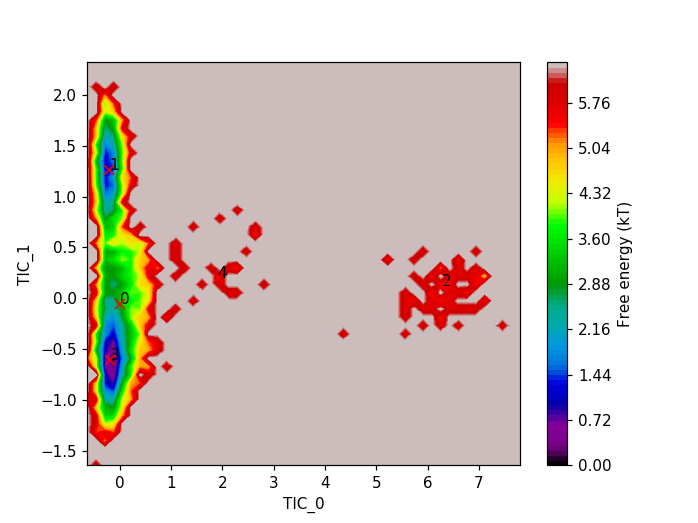

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [7]:
molpx.visualize._plot_ND_FES(np.vstack([iY[:,[0,1]] for iY in Y]), ['TIC_0', 'TIC_1'])
for ii, cc in enumerate(centers):
    plt.plot(cc[0], cc[1], ' xr', zorder=10)
    plt.text(cc[0], cc[1], ii)


## Choose connections among basins and run molpx.visualize.sample

<IPython.core.display.Javascript object>


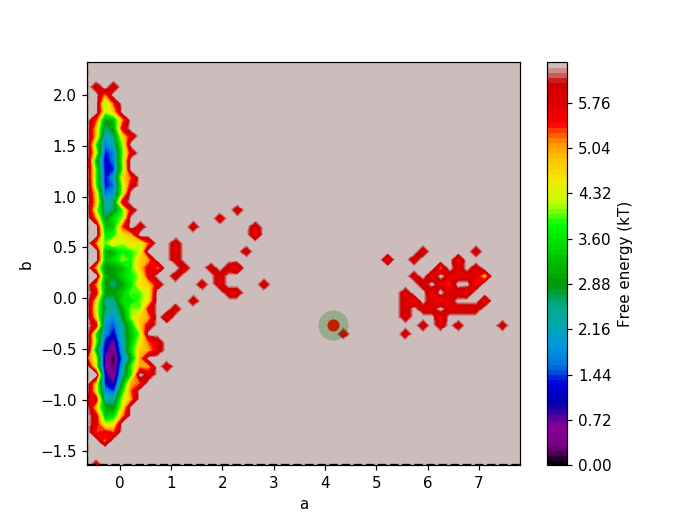

/home/mi/gph82/miniconda3/lib/python3.4/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


caught index error with index 68 (new=68, old=67)


In [9]:
idx1 = 3
idx2 = 2
molpx.visualize._plot_ND_FES(np.vstack([iY[:,[0,1]] for iY in Y]), ['a', 'b'])
igeom = paths[idx1][idx2]["geom"]
ipath = paths[idx1][idx2]["proj"]
plt.plot(ipath[0, 0], ipath[0, 1], ' xr', zorder=10)
plt.plot(ipath[-1,0], ipath[-1,1], ' xg', zorder=10)
plt.plot(ipath[:,0], ipath[:,1], ' o')
iwd = molpx.visualize.sample(ipath, 
                             igeom, plt.gca(), 
                             #clear_lines=False, 
                             n_smooth=4, 
                            radius=True)
iwd.center_view()
#display(iwd)
iwd
